In [20]:
from neo4j import GraphDatabase
import pandas as pd
from openai import OpenAI
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import mysql.connector
import json
from collections import Counter
import os
import re
from dotenv import load_dotenv
load_dotenv()

True

In [21]:
# DB接続処理
# Neo4jに接続
uri = "bolt://localhost:7687"
user = "neo4j"
password = "abcd7890"

# ドライバを作成
driver = GraphDatabase.driver(uri, auth=(user, password))

In [22]:
target="kiwi"

'tomato','basil','cheese_mozzarella_low_moisture_part_skim','olive_oil'


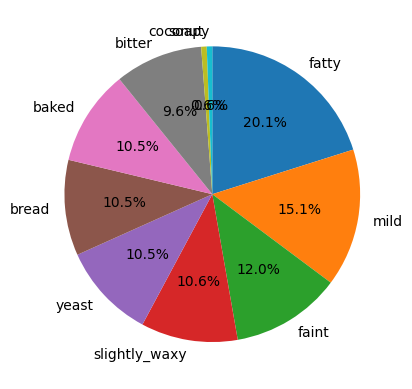

In [41]:
targets=["tomato", "basil", "mozzarella cheese", "olive oil"]

def find_food(tx, search_term):
    find_food_query = """
    CALL db.index.fulltext.queryNodes("food_sub_index_text_search", $search_term)
    YIELD node, score
    ORDER BY score DESC, size(node.name)
    LIMIT 1
    RETURN node.id as node_id, node.name as node_name, score    
    """
    return tx.run(find_food_query, search_term=search_term).data()

def find_aromas(tx, ids):
    print(ids)
    find_aromas_query = """
    MATCH (f:FoodSubType)-[r:SCENTED]->(a:Aroma)
    WHERE f.id IN ['pork_pickled_pork_hocks']
    WITH a.id AS aroma_id, COUNT(f) AS food_count, SUM(r.ratio) AS total_ratio
    RETURN aroma_id, food_count, total_ratio
    ORDER BY total_ratio DESC;
    """
    return tx.run(find_aromas_query, ids=ids).data()
    
with driver.session() as session:
    node_ids = []
    for target in targets:
        result1 = session.execute_read(find_food, target)  
        for record in result1:
            node_ids.append("'"+ record["node_id"] + "'")
    
    result2 = session.execute_read(find_aromas, ",".join(node_ids))
    pd_result = pd.DataFrame(result2)
    
    plt.pie(
    pd_result['total_ratio'], 
    labels=pd_result['aroma_id'], 
    autopct='%1.1f%%',  # 割合表示
    startangle=90,  # 開始角度を指定
    counterclock=False  # 時計回りに表示
)